<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "4C"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/4C/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


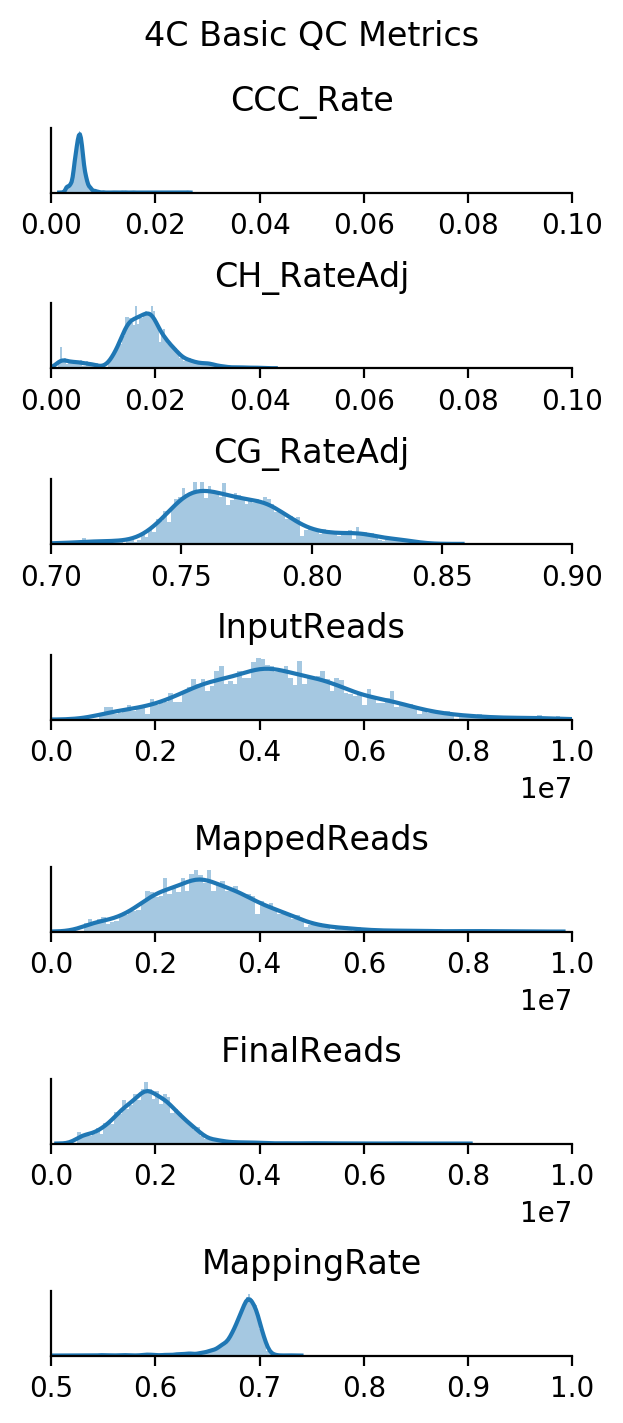

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

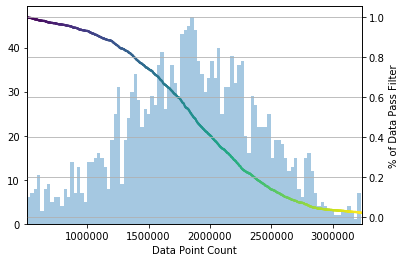

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 1961/1961 (100.0%)
CG_RateAdj passed 1961/1961 (100.0%)
CH_RateAdj passed 1961/1961 (100.0%)
FinalReads passed 1961/1961 (100.0%)
MappingRate passed 1961/1961 (100.0%)
Overall passed 1961/1961 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180417 1006
180419 955


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 257 66.9%
ad002 276 71.9%
ad004 244 63.5%
ad006 254 66.1%
ad007 236 61.5%
ad008 231 60.2%
ad010 231 60.2%
ad012 232 60.4%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
4C_M_0,/gale/raidix/rdx-4/CEMBA_RS1/4C/CEMBA180417_4C...,0.00502,0.75853,0.75731,0.02096,0.01602,1615442.0,4383910,2289176.0,4C,...,-2.882898,-12.583004,-14.955126,59.421948,IT-L23 Cux1,3.944883,8.813937,34.822052,-21.543476,True
4C_M_1,/gale/raidix/rdx-4/CEMBA_RS1/4C/CEMBA180417_4C...,0.00556,0.75415,0.75278,0.02448,0.01903,1430645.0,2934350,2044996.0,4C,...,9.776417,-15.047482,14.317422,30.612959,IT-L5 Cdh8,7.500769,11.409243,-19.223418,-23.973580,True
4C_M_10,/gale/raidix/rdx-4/CEMBA_RS1/4C/CEMBA180417_4C...,0.00533,0.77460,0.77339,0.02252,0.01728,1916029.0,4103524,2864369.0,4C,...,0.523011,-14.799951,1.262765,53.561706,IT-L23 Cux1,-2.787125,9.735402,3.381817,-37.790501,True
4C_M_100,/gale/raidix/rdx-4/CEMBA_RS1/4C/CEMBA180417_4C...,0.00532,0.76672,0.76547,0.02069,0.01545,1658125.0,3917218,2670645.0,4C,...,19.150145,5.315113,-52.484693,-14.600691,CT-L6 Il1rap,-11.719652,-14.560073,17.356393,34.265045,True
4C_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/4C/CEMBA180417_4C...,0.00638,0.77672,0.77529,0.02634,0.02009,1222979.0,2991322,2018248.0,4C,...,-18.549982,-17.158077,-37.265537,-29.096638,CGE-Vip Clstn2,-1.755922,-12.732601,15.259762,11.321638,True
4C_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/4C/CEMBA180417_4C...,0.00498,0.73603,0.73471,0.01756,0.01264,868556.0,2149706,1417348.0,4C,...,5.944896,-18.630726,-45.696244,10.849460,IT-L4 Astn2,5.957447,3.575347,-25.079045,-16.618321,True
4C_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/4C/CEMBA180417_4C...,0.00592,0.76250,0.76109,0.02168,0.01585,1209589.0,2990278,1977383.0,4C,...,20.027994,5.421187,-48.761077,-11.928903,CT-L6 Megf9,-6.211009,-9.139142,-0.023460,29.582810,True
4C_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/4C/CEMBA180417_4C...,0.00694,0.77296,0.77137,0.02993,0.02315,659600.0,1592826,1077956.0,4C,...,2.210898,-13.424463,-0.255797,39.913496,IT-L23 Cux1,-3.712111,5.079693,-13.119347,-12.429763,True
4C_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/4C/CEMBA180417_4C...,0.00656,0.78578,0.78437,0.02849,0.02207,1510988.0,3705358,2512385.0,4C,...,15.330665,-11.038755,34.351054,19.942856,IT-L6 Cadps2,0.277126,-1.883726,-30.265450,13.274321,True
4C_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/4C/CEMBA180417_4C...,0.00598,0.75496,0.75349,0.02446,0.01859,1140424.0,2781118,1893773.0,4C,...,0.580873,-14.487423,0.254037,49.159137,IT-L23 Cux1,-2.410681,9.213130,3.724289,-36.528043,True
